<a href="https://colab.research.google.com/github/lhiwi/FUTURE_DS_01/blob/main/notebooks/%2002_Clean%2BOrganize%2BAnalyse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 02 — Clean, Organize, and Analyze (Superstore)

Goal:
1) Create a clean, analysis-ready dataset (`df_clean`) with minimal, justified transformations.
2) Answer three business questions:
   - Revenue trends over time
   - Top-selling products (and whether they’re profitable)
   - High-value categories and regions (including margin leaks)
3) Export final CSVs for Power BI dashboarding.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Clean + organize (minimal)
We do not “over-clean” since data quality checks showed no missing/invalid values.
We only:
- parse dates
- fix Postal Code type for BI use
- standardize text labels
- add analysis-ready features (month/year, ship delay, margin, flags)


In [ ]:
path = "/content/drive/MyDrive/Future_DS/Sample - Superstore.csv"

df = pd.read_csv(path, encoding="ISO-8859-1")

print("Loaded df shape:", df.shape)
print("First 10 columns:", df.columns.tolist()[:10])
df.head(3)

Loaded df shape: (9994, 21)
First 10 columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City']


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [26]:
# create df_clean and features
df_clean = df.copy()

# 1  Parse dates
df_clean["Order Date"] = pd.to_datetime(df_clean["Order Date"], errors="coerce")
df_clean["Ship Date"]  = pd.to_datetime(df_clean["Ship Date"], errors="coerce")

# 2  Postal Code as text
df_clean["Postal Code"] = df_clean["Postal Code"].astype(str).str.zfill(5)

# 3) Strip whitespace from key categories (prevents duplicate labels)
text_cols = ["Ship Mode","Segment","Country","City","State","Region","Category","Sub-Category"]
for c in text_cols:
    df_clean[c] = df_clean[c].astype(str).str.strip()

# 4) Analysis-ready features
df_clean["Order Year"] = df_clean["Order Date"].dt.year
df_clean["Order Month"] = df_clean["Order Date"].dt.to_period("M").dt.to_timestamp()  # monthly axis
df_clean["Order Quarter"] = df_clean["Order Date"].dt.to_period("Q").astype(str)

df_clean["Ship Delay Days"] = (df_clean["Ship Date"] - df_clean["Order Date"]).dt.days
df_clean["Profit Margin"] = np.where(df_clean["Sales"] != 0, df_clean["Profit"] / df_clean["Sales"], np.nan)
df_clean["Is Loss"] = (df_clean["Profit"] < 0).astype(int)

# Discount bands (helps later for explaining losses)
bins = [-0.0001, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
labels = ["0%", "0–10%", "10–20%", "20–30%", "30–40%", "40–50%", "50%+"]
df_clean["Discount Band"] = pd.cut(df_clean["Discount"], bins=bins, labels=labels)



In [ ]:
# Quick verification
print("df_clean shape:", df_clean.shape)
print("Date missingness:", df_clean[["Order Date","Ship Date"]].isna().sum().to_dict())
print("Ship delay (min/median/max):", int(df_clean["Ship Delay Days"].min()), int(df_clean["Ship Delay Days"].median()), int(df_clean["Ship Delay Days"].max()))
print("Postal Code example:", df_clean["Postal Code"].head(3).tolist())
print("Unique months:", df_clean["Order Month"].nunique(), "| Range:", df_clean["Order Month"].min(), "to", df_clean["Order Month"].max())

df_clean shape: (9994, 28)
Date missingness: {'Order Date': 0, 'Ship Date': 0}
Ship delay (min/median/max): 0 4 7
Postal Code example: ['42420', '42420', '90036']
Unique months: 48 | Range: 2014-01-01 00:00:00 to 2017-12-01 00:00:00


# Analysis

## Revenue trends over time
We aggregate line-item data into monthly totals and add a 3-month rolling average
to see the underlying trend beyond spikes.


In [ ]:
# Monthly revenue and profit trends
import matplotlib.pyplot as plt

# Monthly totals
monthly = (
    df_clean.groupby("Order Month")[["Sales", "Profit"]]
    .sum()
    .sort_index()
)

# Add rolling averages to see the underlying direction
monthly["Sales_3mo_avg"] = monthly["Sales"].rolling(3).mean()
monthly["Profit_3mo_avg"] = monthly["Profit"].rolling(3).mean()

# Show a quick table view (first 6 and last 6 months)
display(monthly.head(6))
display(monthly.tail(6))




,Sales,Profit,Sales_3mo_avg,Profit_3mo_avg
Order Month,,,,
2014-01-01,14236.8950,2450.1907,NaN,NaN
2014-02-01,4519.8920,862.3084,NaN,NaN
2014-03-01,55691.0090,498.7299,24815.932000,1270.409667
2014-04-01,28295.3450,3488.8352,29502.082000,1616.624500
2014-05-01,23648.2870,2738.7096,35878.213667,2242.091567
2014-06-01,34595.1276,4976.5244,28846.253200,3734.689733


,Sales,Profit,Sales_3mo_avg,Profit_3mo_avg
Order Month,,,,
2017-07-01,45264.4160,6952.6212,47502.417300,7172.846567
2017-08-01,63120.8880,9040.9557,53789.009900,8072.304200
2017-09-01,87866.6520,10991.5556,65417.318667,8995.044167
2017-10-01,77776.9232,9275.2755,76254.821067,9769.262267
2017-11-01,118447.8250,9690.1037,94697.133400,9985.644933
2017-12-01,83829.3188,8483.3468,93351.355667,9149.575333


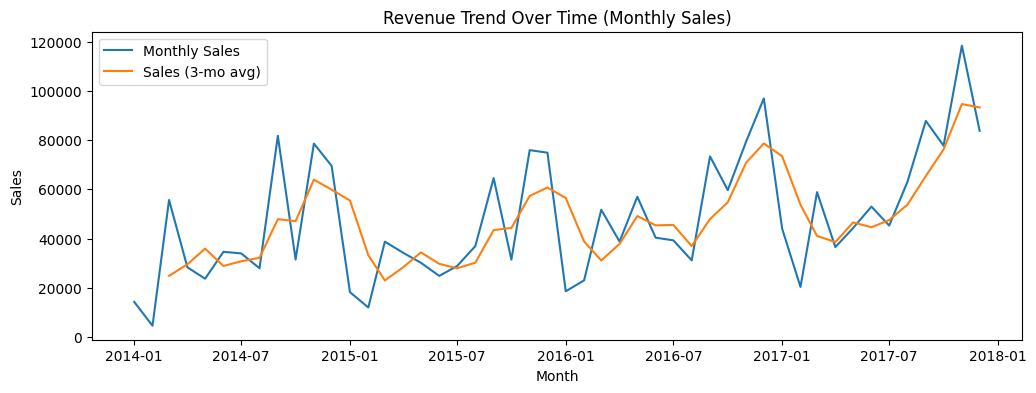

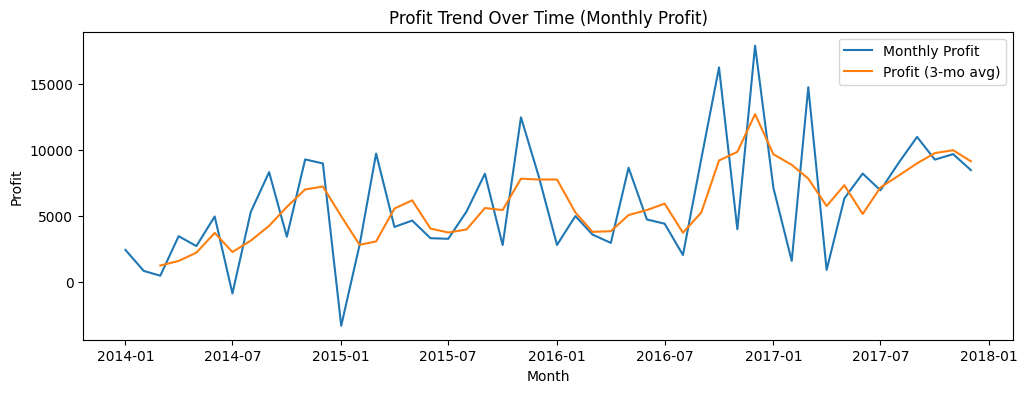

In [ ]:
# Plot Sales
plt.figure(figsize=(12,4))
plt.plot(monthly.index, monthly["Sales"], label="Monthly Sales")
plt.plot(monthly.index, monthly["Sales_3mo_avg"], label="Sales (3-mo avg)")
plt.title("Revenue Trend Over Time (Monthly Sales)")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.show()

# Plot Profit
plt.figure(figsize=(12,4))
plt.plot(monthly.index, monthly["Profit"], label="Monthly Profit")
plt.plot(monthly.index, monthly["Profit_3mo_avg"], label="Profit (3-mo avg)")
plt.title("Profit Trend Over Time (Monthly Profit)")
plt.xlabel("Month")
plt.ylabel("Profit")
plt.legend()
plt.show()



In [ ]:
# Simple growth summary: sales by year
yearly = df_clean.groupby("Order Year")[["Sales", "Profit"]].sum()
display(yearly)

# Identify top 5 sales months and top 5 profit months
top_sales_months = monthly["Sales"].sort_values(ascending=False).head(5)
top_profit_months = monthly["Profit"].sort_values(ascending=False).head(5)

print("Top 5 Sales Months:")
display(top_sales_months)

print("Top 5 Profit Months:")
display(top_profit_months)

,Sales,Profit
Order Year,,
2014,484247.4981,49543.9741
2015,470532.5090,61618.6037
2016,609205.5980,81795.1743
2017,733215.2552,93439.2696


Top 5 Sales Months:


,Sales
Order Month,
2017-11-01,118447.8250
2016-12-01,96999.0430
2017-09-01,87866.6520
2017-12-01,83829.3188
2014-09-01,81777.3508


Top 5 Profit Months:


,Profit
Order Month,
2016-12-01,17885.3093
2016-10-01,16243.1425
2017-03-01,14751.8915
2015-11-01,12474.7884
2017-09-01,10991.5556


## Orders vs AOV vs Profit Margin over time
## What drives revenue growth?
We check whether growth is driven by:
- more orders (volume)
- larger orders (AOV)
- and whether margins compress in peak months


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Monthly order count (unique orders per month)
monthly_orders = (
    df_clean.groupby("Order Month")["Order ID"]
    .nunique()
    .sort_index()
)

# Monthly sales/profit (we already computed monthly_perf earlier, but recompute safely)
monthly_perf = (
    df_clean.groupby("Order Month")[["Sales", "Profit"]]
    .sum()
    .sort_index()
)

# Average Order Value (AOV) per month
monthly_aov = monthly_perf["Sales"] / monthly_orders

# Monthly profit margin (ratio of totals, business-friendly)
monthly_margin = np.where(monthly_perf["Sales"] != 0, monthly_perf["Profit"] / monthly_perf["Sales"], np.nan)
monthly_margin = pd.Series(monthly_margin, index=monthly_perf.index)

# Print a quick table (last 6 months)
summary = pd.DataFrame({
    "Sales": monthly_perf["Sales"],
    "Profit": monthly_perf["Profit"],
    "Orders": monthly_orders,
    "AOV": monthly_aov,
    "Monthly Profit Margin": monthly_margin
})

print("Last 6 months summary:")
print(summary.tail(6))




Last 6 months summary:
                   Sales      Profit  Orders         AOV  \
Order Month                                                
2017-07-01    45264.4160   6952.6212     111  407.787532   
2017-08-01    63120.8880   9040.9557     111  568.656649   
2017-09-01    87866.6520  10991.5556     226  388.790496   
2017-10-01    77776.9232   9275.2755     147  529.094716   
2017-11-01   118447.8250   9690.1037     261  453.823084   
2017-12-01    83829.3188   8483.3468     224  374.238030   

             Monthly Profit Margin  
Order Month                         
2017-07-01                0.153600  
2017-08-01                0.143232  
2017-09-01                0.125094  
2017-10-01                0.119255  
2017-11-01                0.081809  
2017-12-01                0.101198  


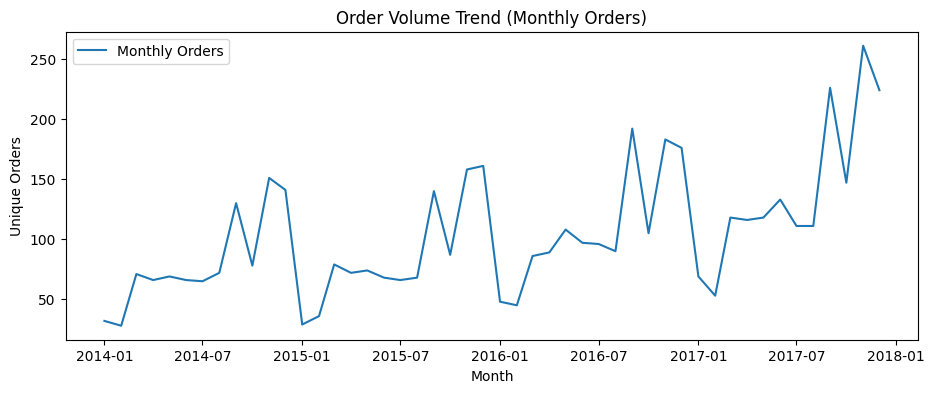

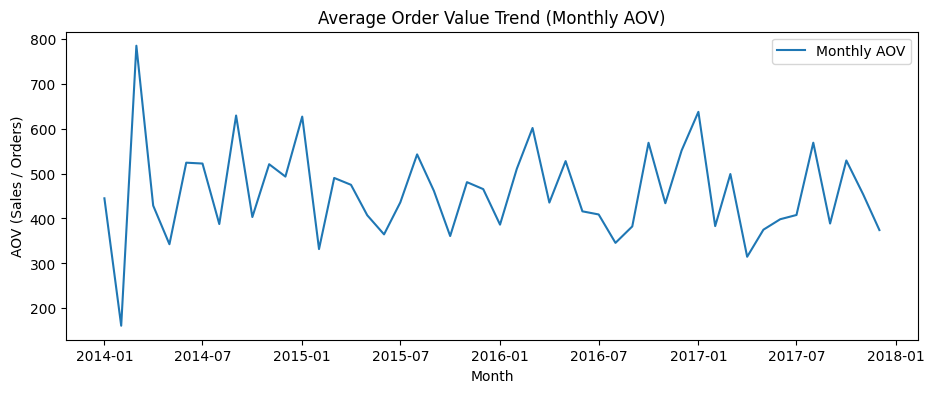

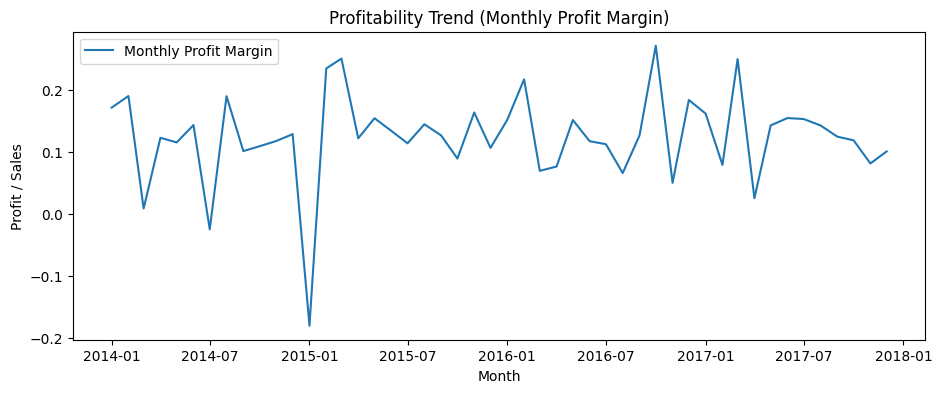

In [ ]:
# Plot Orders
plt.figure(figsize=(11,4))
plt.plot(monthly_orders.index, monthly_orders, label="Monthly Orders")
plt.title("Order Volume Trend (Monthly Orders)")
plt.xlabel("Month")
plt.ylabel("Unique Orders")
plt.legend()
plt.show()

# Plot AOV
plt.figure(figsize=(11,4))
plt.plot(monthly_aov.index, monthly_aov, label="Monthly AOV")
plt.title("Average Order Value Trend (Monthly AOV)")
plt.xlabel("Month")
plt.ylabel("AOV (Sales / Orders)")
plt.legend()
plt.show()

# Plot Monthly Profit Margin
plt.figure(figsize=(11,4))
plt.plot(monthly_margin.index, monthly_margin, label="Monthly Profit Margin")
plt.title("Profitability Trend (Monthly Profit Margin)")
plt.xlabel("Month")
plt.ylabel("Profit / Sales")
plt.legend()
plt.show()

## Top-selling products
We rank products by total Sales and bring Profit + Margin to distinguish
“revenue heroes” from “revenue but loss-making” items.


In [ ]:
# Top products by total Sales (with Profit and Profit Margin)
prod_perf = (
    df_clean.groupby(["Product ID", "Product Name"])
    .agg(
        Sales=("Sales", "sum"),
        Profit=("Profit", "sum"),
        Quantity=("Quantity", "sum"),
        Orders=("Order ID", "nunique")
    )
    .reset_index()
)

prod_perf["Profit Margin"] = np.where(prod_perf["Sales"] != 0, prod_perf["Profit"] / prod_perf["Sales"], np.nan)

top10_sales_products = prod_perf.sort_values("Sales", ascending=False).head(10)

top10_sales_products[["Product ID","Product Name","Sales","Profit","Profit Margin","Quantity","Orders"]]


,Product ID,Product Name,Sales,Profit,Profit Margin,Quantity,Orders
1640,TEC-CO-10004722,Canon imageCLASS 2200 Advanced Copier,61599.824,2.519993e+04,4.090909e-01,20,5
787,OFF-BI-10003527,Fellowes PB500 Electric Punch Plastic Comb Bin...,27453.384,7.753039e+03,2.824074e-01,31,10
1669,TEC-MA-10002412,Cisco TelePresence System EX90 Videoconferenci...,22638.480,-1.811078e+03,-8.000000e-02,6,1
82,FUR-CH-10002024,HON 5400 Series Task Chairs for Big and Tall,21870.576,5.684342e-14,2.599082e-18,39,8
701,OFF-BI-10001359,GBC DocuBind TL300 Electric Binding System,19823.479,2.233505e+03,1.126697e-01,37,11
667,OFF-BI-10000545,GBC Ibimaster 500 Manual ProClick Binding System,19024.500,7.609800e+02,4.000000e-02,48,9
1630,TEC-CO-10001449,Hewlett Packard LaserJet 3310 Copier,18839.686,6.983884e+03,3.707006e-01,38,8
1657,TEC-MA-10001127,HP Designjet T520 Inkjet Large Format Printer ...,18374.895,4.094977e+03,2.228571e-01,12,3
858,OFF-BI-10004995,GBC DocuBind P400 Electric Binding System,17965.068,-1.878166e+03,-1.045455e-01,27,6
1443,OFF-SU-10000151,High Speed Automatic Electric Letter Opener,17030.312,-2.620048e+02,-1.538462e-02,11,3


## Discount check for top sellers
We summarize discount levels for the Top 10 products to see if losses correlate with heavy discounting.


In [ ]:
# Discount and profitablity checks for top 10 products
top10_ids = top10_sales_products["Product ID"].tolist()

top10_detail = (
    df_clean[df_clean["Product ID"].isin(top10_ids)]
    .groupby(["Product ID", "Product Name"])
    .agg(
        Sales=("Sales","sum"),
        Profit=("Profit","sum"),
        Quantity=("Quantity","sum"),
        Orders=("Order ID","nunique"),
        Avg_Discount=("Discount","mean"),
        Max_Discount=("Discount","max"),
        Min_Discount=("Discount","min")
    )
    .reset_index()
)

top10_detail["Profit Margin"] = np.where(top10_detail["Sales"] != 0, top10_detail["Profit"]/top10_detail["Sales"], np.nan)
top10_detail["Loss Flag"] = (top10_detail["Profit"] < 0).astype(int)

# Sort by Sales to keep same ordering
top10_detail = top10_detail.sort_values("Sales", ascending=False)

top10_detail[["Product ID","Product Name","Sales","Profit","Profit Margin","Avg_Discount","Min_Discount","Max_Discount","Orders","Quantity","Loss Flag"]]


,Product ID,Product Name,Sales,Profit,Profit Margin,Avg_Discount,Min_Discount,Max_Discount,Orders,Quantity,Loss Flag
7,TEC-CO-10004722,Canon imageCLASS 2200 Advanced Copier,61599.824,2.519993e+04,4.090909e-01,0.120000,0.0,0.4,5,20,0
3,OFF-BI-10003527,Fellowes PB500 Electric Punch Plastic Comb Bin...,27453.384,7.753039e+03,2.824074e-01,0.240000,0.0,0.8,10,31,0
9,TEC-MA-10002412,Cisco TelePresence System EX90 Videoconferenci...,22638.480,-1.811078e+03,-8.000000e-02,0.500000,0.5,0.5,1,6,1
0,FUR-CH-10002024,HON 5400 Series Task Chairs for Big and Tall,21870.576,5.684342e-14,2.599082e-18,0.200000,0.0,0.3,8,39,0
2,OFF-BI-10001359,GBC DocuBind TL300 Electric Binding System,19823.479,2.233505e+03,1.126697e-01,0.300000,0.0,0.8,11,37,0
1,OFF-BI-10000545,GBC Ibimaster 500 Manual ProClick Binding System,19024.500,7.609800e+02,4.000000e-02,0.522222,0.0,0.8,9,48,0
6,TEC-CO-10001449,Hewlett Packard LaserJet 3310 Copier,18839.686,6.983884e+03,3.707006e-01,0.200000,0.0,0.4,8,38,0
8,TEC-MA-10001127,HP Designjet T520 Inkjet Large Format Printer ...,18374.895,4.094977e+03,2.228571e-01,0.166667,0.0,0.5,3,12,0
4,OFF-BI-10004995,GBC DocuBind P400 Electric Binding System,17965.068,-1.878166e+03,-1.045455e-01,0.450000,0.0,0.8,6,27,1
5,OFF-SU-10000151,High Speed Automatic Electric Letter Opener,17030.312,-2.620048e+02,-1.538462e-02,0.066667,0.0,0.2,3,11,1


## High-value categories
We compute sales/profit shares and margin per category to identify:
- profit engines
- revenue-heavy but low-profit categories (margin leaks)


In [22]:
# Category performance (Sales, Profit, Margin, Share)
total_sales = df_clean["Sales"].sum()
total_profit = df_clean["Profit"].sum()

cat_perf = (
    df_clean.groupby("Category")
    .agg(
        Sales=("Sales","sum"),
        Profit=("Profit","sum"),
        Quantity=("Quantity","sum"),
        Orders=("Order ID","nunique"),
        Avg_Discount=("Discount","mean")
    )
    .reset_index()
)

cat_perf["Profit Margin"] = np.where(cat_perf["Sales"] != 0, cat_perf["Profit"] / cat_perf["Sales"], np.nan)
cat_perf["Sales Share %"] = (cat_perf["Sales"] / total_sales) * 100
cat_perf["Profit Share %"] = (cat_perf["Profit"] / total_profit) * 100

cat_perf = cat_perf.sort_values("Sales", ascending=False)

cat_perf[["Category","Sales","Sales Share %","Profit","Profit Share %","Profit Margin","Orders","Quantity","Avg_Discount"]]


,Category,Sales,Sales Share %,Profit,Profit Share %,Profit Margin,Orders,Quantity,Avg_Discount
2,Technology,836154.0330,36.398821,145454.9481,50.787870,0.173957,1544,6939,0.132323
0,Furniture,741999.7953,32.300171,18451.2728,6.442551,0.024867,1764,8028,0.173923
1,Office Supplies,719047.0320,31.301008,122490.8008,42.769579,0.170352,3742,22906,0.157285


## High-value regions
Same idea as category: identify regions driving sales and profit, and where discounting hurts margins.


In [23]:
# Region performance
total_sales = df_clean["Sales"].sum()
total_profit = df_clean["Profit"].sum()

region_perf = (
    df_clean.groupby("Region")
    .agg(
        Sales=("Sales","sum"),
        Profit=("Profit","sum"),
        Quantity=("Quantity","sum"),
        Orders=("Order ID","nunique"),
        Avg_Discount=("Discount","mean")
    )
    .reset_index()
)

region_perf["Profit Margin"] = np.where(region_perf["Sales"] != 0, region_perf["Profit"] / region_perf["Sales"], np.nan)
region_perf["Sales Share %"] = (region_perf["Sales"] / total_sales) * 100
region_perf["Profit Share %"] = (region_perf["Profit"] / total_profit) * 100

region_perf = region_perf.sort_values("Sales", ascending=False)

region_perf[["Region","Sales","Sales Share %","Profit","Profit Share %","Profit Margin","Orders","Quantity","Avg_Discount"]]


,Region,Sales,Sales Share %,Profit,Profit Share %,Profit Margin,Orders,Quantity,Avg_Discount
3,West,725457.8245,31.580078,108418.4489,37.855997,0.149448,1611,12266,0.109335
1,East,678781.2400,29.548188,91522.7800,31.956610,0.134834,1401,10618,0.145365
0,Central,501239.8908,21.819594,39706.3625,13.864098,0.079216,1175,8780,0.240353
2,South,391721.9050,17.052140,46749.4303,16.323295,0.119343,822,6209,0.147253


## Category & Region performance
This identifies:
- best growth pockets (high sales + strong margin)
- biggest margin leaks (high sales but weak profit/margin)


In [29]:
cat_region = (
    df_clean.groupby(["Region","Category"])
    .agg(
        Sales=("Sales","sum"),
        Profit=("Profit","sum"),
        Orders=("Order ID","nunique"),
        Avg_Discount=("Discount","mean"),
    )
    .reset_index()
)

cat_region["Profit Margin"] = cat_region["Profit"] / cat_region["Sales"]
# top revenue pockets
top_sales = cat_region.sort_values("Sales", ascending=False).head(8)
display(top_sales[["Region","Category","Sales","Profit","Profit Margin","Avg_Discount","Orders"]])


,Region,Category,Sales,Profit,Profit Margin,Avg_Discount,Orders
5,East,Technology,264973.9810,47462.0351,0.179120,0.143364,443
9,West,Furniture,252612.7435,11504.9503,0.045544,0.131400,595
11,West,Technology,251991.8320,44303.6496,0.175814,0.133890,490
10,West,Office Supplies,220853.2490,52609.8490,0.238212,0.093358,1169
3,East,Furniture,208291.2040,3046.1658,0.014625,0.154077,488
4,East,Office Supplies,205516.0550,41014.5791,0.199569,0.142932,1074
2,Central,Technology,170416.3120,33697.4320,0.197736,0.133095,356
1,Central,Office Supplies,167026.4150,8879.9799,0.053165,0.252743,880


In [30]:
# Worst profit pockets
worst_profit = cat_region.sort_values("Profit", ascending=True).head(8)
display(worst_profit[["Region","Category","Sales","Profit","Profit Margin","Avg_Discount","Orders"]])


,Region,Category,Sales,Profit,Profit Margin,Avg_Discount,Orders
0,Central,Furniture,163797.1638,-2871.0494,-0.017528,0.297380,403
3,East,Furniture,208291.2040,3046.1658,0.014625,0.154077,488
6,South,Furniture,117298.6840,6771.2061,0.057726,0.121536,278
1,Central,Office Supplies,167026.4150,8879.9799,0.053165,0.252743,880
9,West,Furniture,252612.7435,11504.9503,0.045544,0.131400,595
7,South,Office Supplies,125651.3130,19986.3928,0.159062,0.167437,619
8,South,Technology,148771.9080,19991.8314,0.134379,0.107850,255
2,Central,Technology,170416.3120,33697.4320,0.197736,0.133095,356


## Export for Power BI
We export:
- line-item clean table (best for product-level visuals)
- order-level table (best for order KPIs like AOV and order profitability)


In [31]:
out_line = "/content/drive/MyDrive/Future_DS/superstore_clean_for_powerbi.csv"
df_clean.to_csv(out_line, index=False)

order_tbl = (
    df_clean.groupby("Order ID")
    .agg(
        Order_Date=("Order Date","min"),
        Ship_Date=("Ship Date","max"),
        Customer_ID=("Customer ID","first"),
        Segment=("Segment","first"),
        City=("City","first"),
        State=("State","first"),
        Region=("Region","first"),
        Sales=("Sales","sum"),
        Profit=("Profit","sum"),
        Lines=("Row ID","count"),
        Items=("Quantity","sum"),
        Avg_Discount=("Discount","mean"),
    )
    .reset_index()
)

order_tbl["Ship Delay Days"] = (order_tbl["Ship_Date"] - order_tbl["Order_Date"]).dt.days
order_tbl["Profit Margin"] = np.where(order_tbl["Sales"] != 0, order_tbl["Profit"]/order_tbl["Sales"], np.nan)
order_tbl["Is Loss"] = (order_tbl["Profit"] < 0).astype(int)

out_order = "/content/drive/MyDrive/Future_DS/superstore_orders_for_powerbi.csv"
order_tbl.to_csv(out_order, index=False)

print("Saved:", out_line)
print("Saved:", out_order)


Saved: /content/drive/MyDrive/Future_DS/superstore_clean_for_powerbi.csv
Saved: /content/drive/MyDrive/Future_DS/superstore_orders_for_powerbi.csv
